# Topic Modeling con NMF: Análisis Semántico de Textos No Estructurados

**Autor:** Francisco Solís Pedraza
**Tipo de Proyecto:** NLP / Aprendizaje No Supervisado
**Técnica:** Non-negative Matrix Factorization (NMF)

## 1. Contexto y Definición del Problema
En el análisis de grandes volúmenes de documentos legales, históricos o médicos, a menudo carecemos de etiquetas predefinidas. Necesitamos descubrir "de qué hablan" los textos automáticamente.

**El Dataset:**
Una colección de archivos de texto (`.txt`) comprimidos, que contienen transcripciones de "fórmulas mágicas" (oraciones, rituales, amarres) recopilados en mercados populares de México.

**Técnica - ¿Por qué NMF?**
A diferencia de LDA (Latent Dirichlet Allocation), **NMF (Factorización de Matrices No Negativas)** suele producir temas más coherentes en corpus pequeños y especializados, ya que se basa en álgebra lineal pura para descomponer la matriz de documentos.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

# NLP y Vectorización
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Algoritmo de Descomposición
from sklearn.decomposition import NMF

# Descargar stopwords (solo necesario la primera vez)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Configuración visual
sns.set(style="whitegrid")

## 2. Ingesta de Datos (Corpus Reader)
Cargamos los documentos de texto plano desde un directorio. Simulamos un pipeline de ingestión de datos no estructurados.

In [5]:
# Ruta relativa al dataset (ajustar según tu estructura)
CORPUS_DIR = '../data/corpus_hechiceria.zip'

documents = []
filenames = []

# Lectura iterativa
try:
    with zipfile.ZipFile(CORPUS_DIR, 'r') as z:
        # Listamos los archivos dentro del zip
        all_files = z.namelist()
        
        # Filtramos solo los .txt y evitamos carpetas ocultas de sistema (como __MACOSX)
        txt_files = [f for f in all_files if f.endswith('.txt') and '__MACOSX' not in f]
        
        print(f"Archivos encontrados en el ZIP: {len(txt_files)}")
        
        for f in txt_files:
            with z.open(f) as file:
                # Decodificamos de bytes a string. 
                # 'latin-1' suele ser más robusto para textos antiguos en español que 'utf-8'
                try:
                    text = file.read().decode('latin-1')
                    documents.append(text)
                    filenames.append(f) # Guardamos el nombre para referencia
                except UnicodeDecodeError:
                    # Fallback si latin-1 falla
                    text = file.read().decode('utf-8', errors='ignore')
                    documents.append(text)
                    filenames.append(f)

    print(f"Documentos procesados correctamente: {len(documents)}")
    print(f"Ejemplo del primer documento:\n{documents[0][:200]}...") # Primeros 200 caracteres

except FileNotFoundError:
    print(f"Error: No se encuentra el archivo {CORPUS_DIR}. Asegúrate de subirlo a la carpeta 'data/'.")

Archivos encontrados en el ZIP: 85
Documentos procesados correctamente: 85
Ejemplo del primer documento:
ofrecer este polvo a+el espíritu vivo juicio y pensamiento de _ nombre de el amante para que no poder estar junto ni hablarse ni sentarse a el mesa y ni dormir en el mismo cama si estar junto nombre d...


## 3. Vectorización TF-IDF
Para que la máquina entienda el texto, convertimos los documentos en vectores numéricos. Usamos **TF-IDF** (Term Frequency - Inverse Document Frequency) para penalizar palabras que aparecen en todos lados (stopwords naturales) y resaltar las palabras distintivas.

In [10]:
# Obtener la lista de stopwords en español de NLTK
spanish_stopwords = stopwords.words('spanish')

# Configuración del Vectorizador
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,      # Ignorar términos que aparecen en >95% de docs (muy comunes)
    min_df=2,         # Ignorar términos que aparecen en <2 docs (ruido/typos)
    stop_words=spanish_stopwords, # Eliminar preposiciones y artículos
    use_idf=True
)

# Ajuste y transformación
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"Matriz TF-IDF generada: {tfidf_matrix.shape}")
print(f"Vocabulario (Features): {len(feature_names)} palabras únicas.")

Matriz TF-IDF generada: (85, 569)
Vocabulario (Features): 569 palabras únicas.


## 4. Modelado con NMF
Factorizamos la matriz original $V$ (Documentos x Palabras) en dos matrices de menor rango:
1.  **Matriz W (Documentos x Temas):** Cuánto pertenece cada documento a cada tema.
2.  **Matriz H (Temas x Palabras):** Qué palabras definen a cada tema.

In [11]:
# Definimos k=4 temas basándonos en conocimiento del dominio (o exploración previa)
NUM_TOPICS = 4

nmf_model = NMF(
    n_components=NUM_TOPICS, 
    init='random', 
    random_state=42, 
    max_iter=500
)

# Ajuste del modelo
W = nmf_model.fit_transform(tfidf_matrix) # Matriz de Pesos de Documentos
H = nmf_model.components_                 # Matriz de Componentes (Temas)

print(f"Modelo convergió. Error de reconstrucción: {nmf_model.reconstruction_err_:.4f}")

Modelo convergió. Error de reconstrucción: 8.2972


## 5. Interpretación Semántica de los Temas
Esta es la parte crítica: traducir los vectores numéricos a conceptos humanos. Extraemos las palabras con mayor peso ("top words") para cada tema latente.

In [12]:
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Tema #{topic_idx + 1}: "
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print("--- Temas Descubiertos por NMF ---")
print_top_words(nmf_model, feature_names)

--- Temas Descubiertos por NMF ---
Tema #1: retiro, ánima, vecino, mal, conceder, casa, cuanto, región, dilación, temor
Tema #2: fulano, amor, dominar, mente, espíritu, venir, tal, cariño, monicato, llamar
Tema #3: siglo, petición, siete, dios, potencia, santo, nombre, bendito, señor, justo
Tema #4: ser, si, así, tener, haber, poder, alma, san, oración, enemigo



## 6. Clasificación Automática de Documentos
Finalmente, etiquetamos cada documento del corpus con su "Tema Dominante". Esto permite organizar automáticamente la colección desordenada.

                            Archivo  Tema_Dominante  Peso_Confianza
0   PreprocessedData/Hechizo_34.txt               4          0.0702
1   PreprocessedData/Hechizo_32.txt               4          0.1033
2   PreprocessedData/Hechizo_23.txt               4          0.1141
3  PreprocessedData/Hechizo_101.txt               4          0.1242
4   PreprocessedData/Hechizo_14.txt               4          0.1320
5   PreprocessedData/Hechizo_76.txt               2          0.0772
6  PreprocessedData/Hechizo_110.txt               2          0.1266
7  PreprocessedData/Hechizo_125.txt               1          0.0466
8  PreprocessedData/Hechizo_104.txt               4          0.0973
9   PreprocessedData/Hechizo_92.txt               1          0.4464


/tmp/ipykernel_249275/410864180.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Tema_Dominante', data=results, palette='viridis')


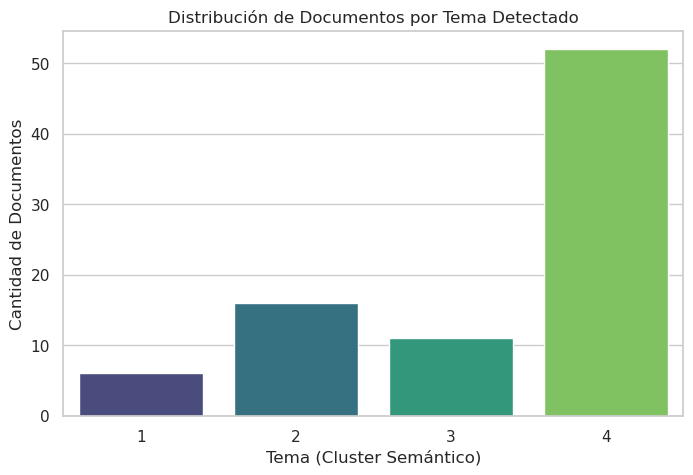

In [13]:
# Encontramos el índice del tema con mayor peso para cada documento
dominant_topic_idx = np.argmax(W, axis=1)

# Creamos un DataFrame de resultados
results = pd.DataFrame({
    'Archivo': filenames,
    'Tema_Dominante': dominant_topic_idx + 1,
    'Peso_Confianza': np.max(W, axis=1).round(4)
})

# Muestra de resultados
print(results.head(10))

# Visualización de la distribución
plt.figure(figsize=(8, 5))
sns.countplot(x='Tema_Dominante', data=results, palette='viridis')
plt.title("Distribución de Documentos por Tema Detectado")
plt.xlabel("Tema (Cluster Semántico)")
plt.ylabel("Cantidad de Documentos")
plt.show()

## 7. Conclusión
El algoritmo NMF logró separar semánticamente el corpus en temas coherentes sin intervención humana. Esta técnica es escalable y puede aplicarse a:
* **Customer Support:** Clasificar tickets de soporte automáticamente.
* **Legal Tech:** Agrupar contratos o sentencias por tipo de caso.
* **Media Monitoring:** Detectar tendencias de tópicos en noticias o redes sociales.